# info

# init

In [58]:
import sys, os, copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
plt.style.use("seaborn-pastel")

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.externals import joblib

In [63]:
def config_plot(h=10):
    plt.rcParams["font.size"] = 1.5*h
    return (1.62*h, h)

# load

In [3]:
path_doc = "../doc/"

In [50]:
path_data = "../data/"
path_clns = path_data + "clns/"
path_mid = path_data + "mid/"

In [7]:
_dic_data = dict()
for d in os.listdir(path_clns):
    fn = d.split(".")[0]
    _dic_data[fn] = pd.read_csv(path_clns+d, index_col=0)

In [8]:
def get_mart(log=False, oh=False, tgt=False, fam=False, ps=False):
    dic_data = copy.deepcopy(_dic_data)
    yname = "survived"
    y = dic_data["y"]
    test_id = y[y[yname].isna()].index
    
    nums = dic_data["num_z"]
    cats = list()

    onehot = [v for k, v in dic_data.items() if ("onehot" in k) and not ("family" in k or "parch_sibsp" in k)]
    onehot_fam = [v for k, v in dic_data.items() if ("onehot" in k) and ("family" in k)]
    onehot_ps = [v for k, v in dic_data.items() if ("onehot" in k) and ("parch_sibsp" in k)]
    
    tgtenc = [v for k, v in dic_data.items() if ("tgt" in k) and not ("family" in k or "parch_sibsp" in k)]
    tgt_fam = [v for k, v in dic_data.items() if ("tgt" in k) and ("family" in k)]
    tgt_ps = [v for k, v in dic_data.items() if ("tgt" in k) and ("parch_sibsp" in k)]

    if log:
        nums = dic_data["num_logz"]
    if oh:
        cats += onehot
    if tgt:
        cats += tgtenc
    if fam:
        if oh:
            cats += onehot_fam
        if tgt:
            cats += onehot_ps
    if ps:
        if oh:
            cats += tgt_fam
        if tgt:
            cats += tgt_ps
            
    mart = pd.concat([y, nums, *cats], axis=1)
    train, test = mart[~mart.index.isin(test_id)], mart[mart.index.isin(test_id)]
    train_X, train_y, test_X = train.drop(yname, 1), train[yname], test.drop(yname, 1)
    return train_X, train_y, test_X

In [27]:
X, y, _ = get_mart(1,0,1,1,1)

In [26]:
model = joblib.load("../model/lr_10111.pkl")
params = model.get_params()

# pred

In [28]:
kf = StratifiedKFold(n_splits=3)

In [43]:
res = list()
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    lr = LogisticRegression(**params)
    lr.fit(X_train, y_train)
    p = lr.predict_proba(X_test)[:,1]
    proba = y_test.copy().to_frame()
    proba["p"] = p
    res.append(proba)

In [47]:
likelihood = pd.concat(res)
likelihood["likelihood"] = (likelihood.p**likelihood.survived)*((1-likelihood.p)**(1-likelihood.survived))
likelihood.T

id,3,4,7,9,11,13,16,19,23,24,...,867,868,869,871,872,873,874,879,884,888
survived,1.000000,0.00000,0.000000,1.000000,1.000000,0.00000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,1.00000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
p,0.877963,0.10335,0.806727,0.904835,0.759574,0.03587,0.223193,0.618242,0.439323,0.930081,...,0.374648,0.138682,0.445087,0.89167,0.243388,0.091622,0.849117,0.889442,0.128216,0.557768
likelihood,0.877963,0.89665,0.193273,0.904835,0.759574,0.96413,0.776807,0.618242,0.439323,0.069919,...,0.625352,0.861318,0.445087,0.89167,0.756612,0.908378,0.849117,0.889442,0.871784,0.442232


In [48]:
likelihood.to_csv(path_mid+"likelihood.csv")

# plot

In [82]:
cats = pd.read_csv(path_mid+"cats.csv", index_col=0)
nums = pd.read_csv(path_mid+"nums.csv", index_col=0)
bools = pd.read_csv(path_mid+"bools.csv", index_col=0)
cats = cats.join(nums[["parch", "sibsp"]])

In [81]:
y = likelihood[["likelihood"]]

## cat

In [115]:
data = cats.copy()
data = data.dropna()
data = data.astype(str)
data = data.join(y, how="inner")

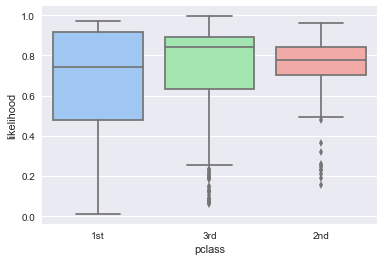

In [116]:
sns.boxplot(data=data, x="pclass", y="likelihood")

In [97]:
def plot_cat(data, x):
    p = path_doc + "img/error_cat_%s.png"%x
    plt.figure(figsize=config_plot())
    for v in data[x].unique():
        subs = data[data[x]==v]
        sns.distplot(subs["likelihood"], label=v)
    plt.legend()
    print("###", x)
    print("![](%s)"%p)
    plt.savefig(p)

C:\Users\keisu\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


### embarked
![](../doc/img/error_cat_embarked.png)
### pclass
![](../doc/img/error_cat_pclass.png)
### sex
![](../doc/img/error_cat_sex.png)
### parch
![](../doc/img/error_cat_parch.png)
### sibsp
![](../doc/img/error_cat_sibsp.png)


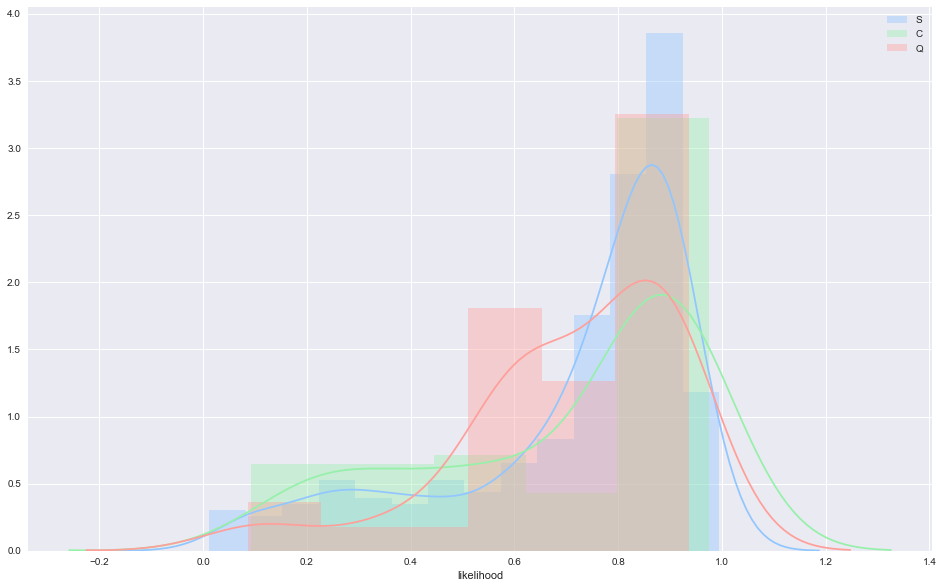

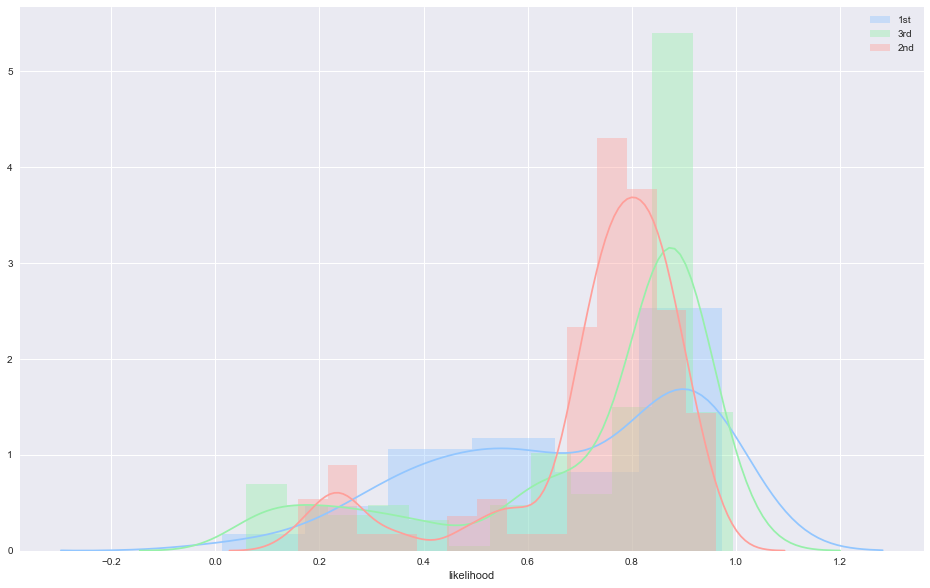

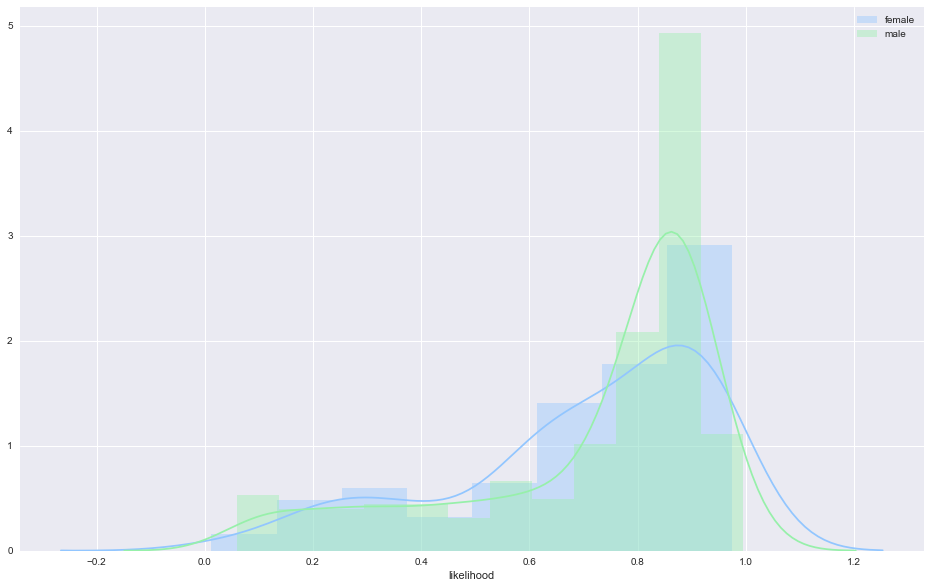

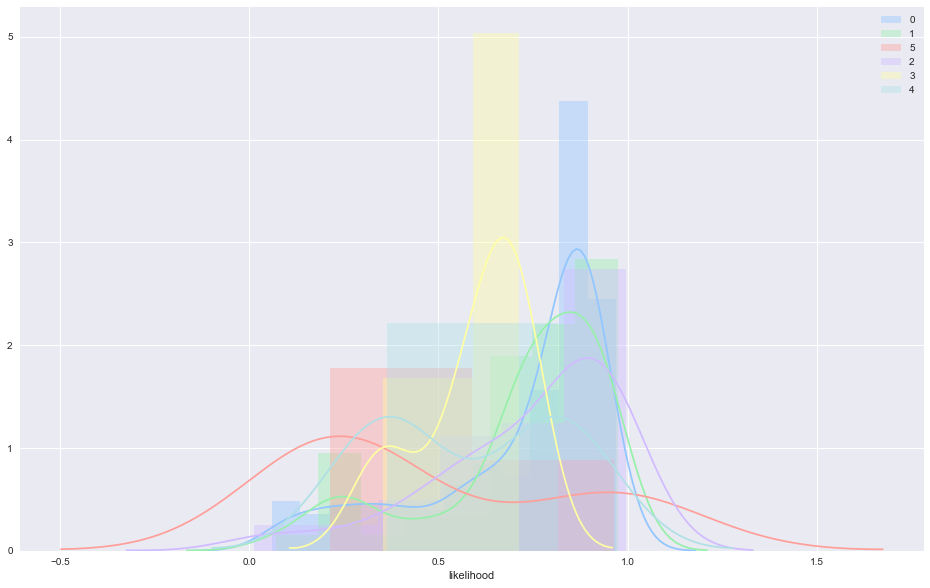

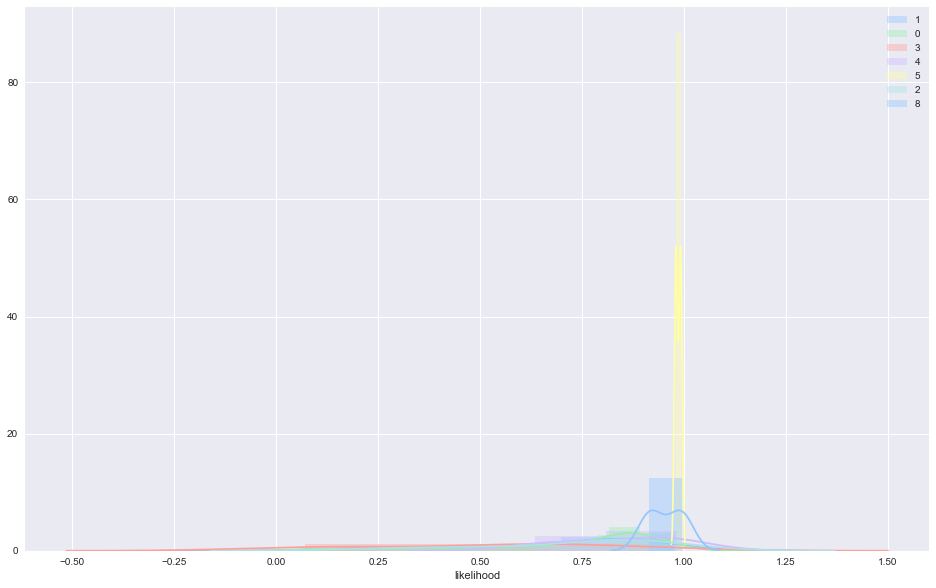

In [98]:
for x in data.drop("likelihood",1):
    plot_cat(data, x)

## bool

In [99]:
data = bools.copy()
data = data.dropna()
data = data.astype(str)
data = data.join(y, how="inner")

C:\Users\keisu\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


### isna_age
![](../doc/img/error_cat_isna_age.png)
### iszero_fare
![](../doc/img/error_cat_iszero_fare.png)


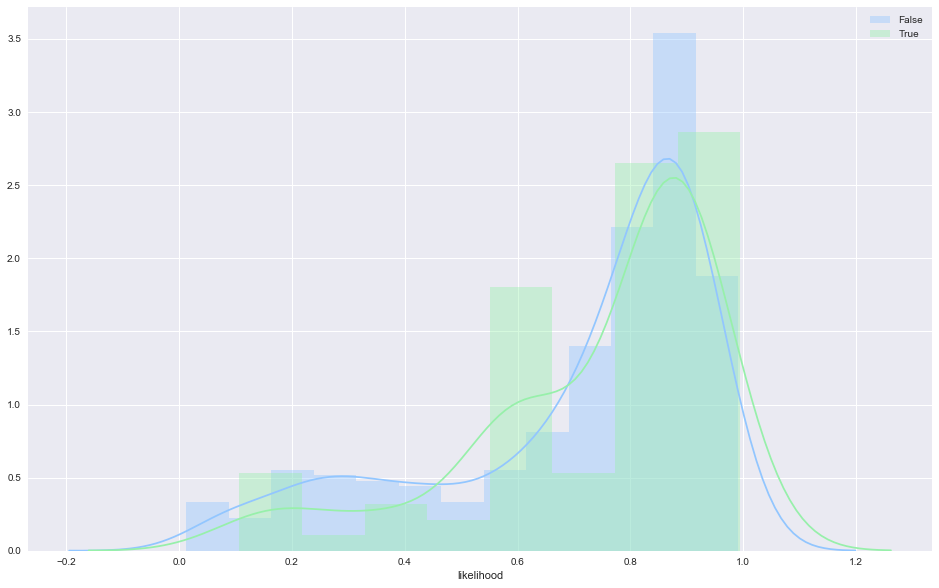

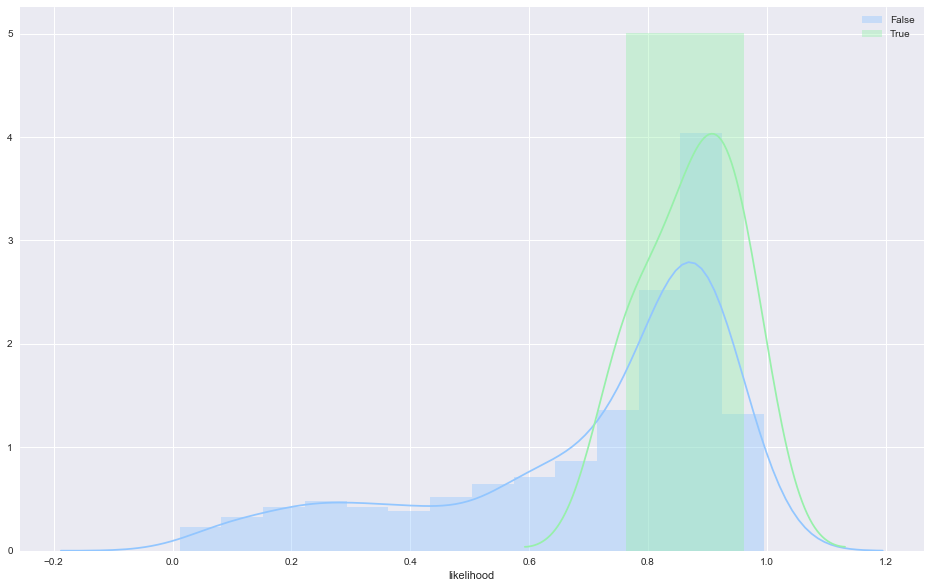

In [100]:
for x in data.drop("likelihood",1):
    plot_cat(data, x)

## num

In [124]:
data = nums.copy()
data = data.dropna()
data = data.join(y, how="inner")

C:\Users\keisu\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


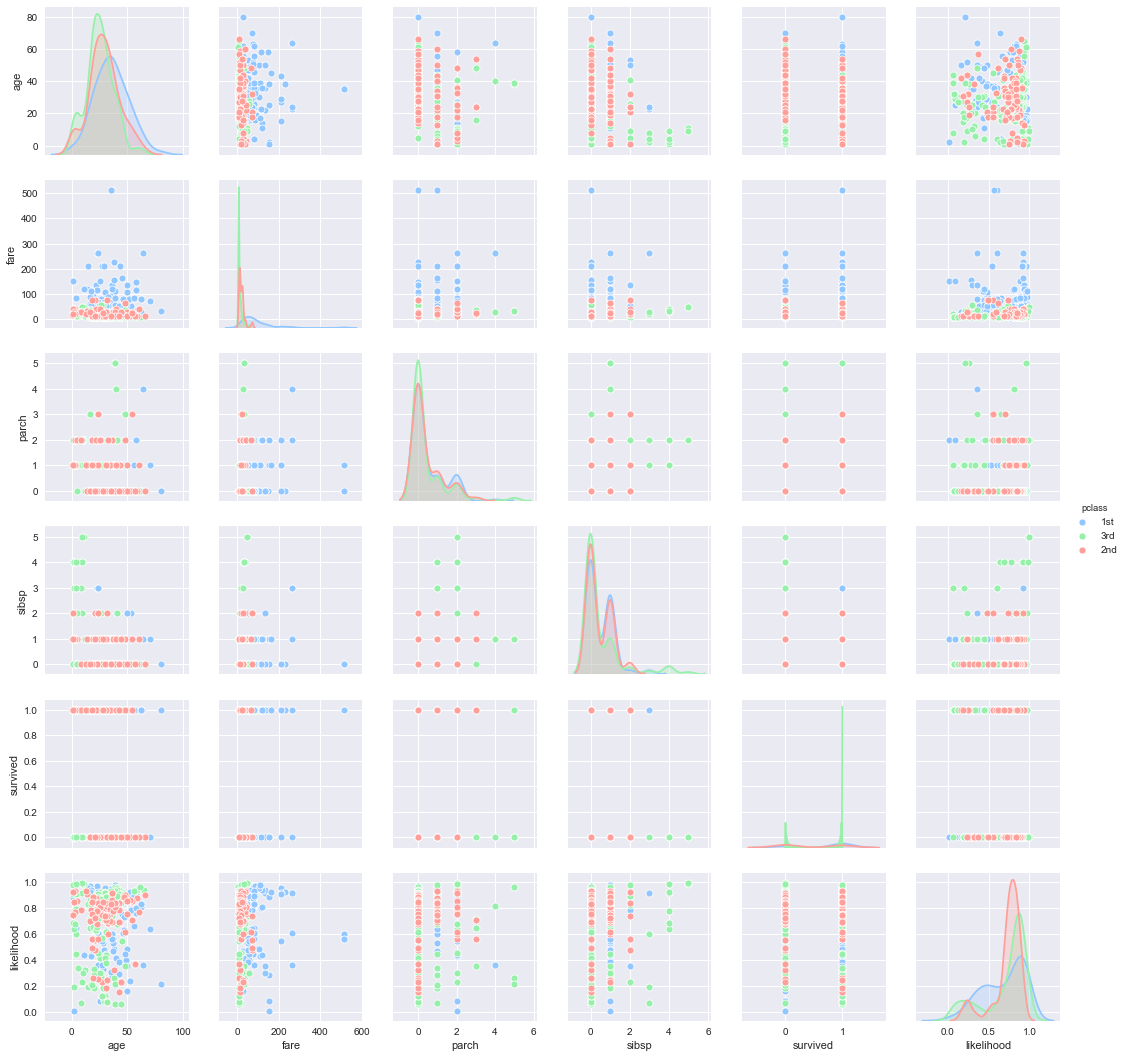

In [105]:
sns.pairplot(data.join(cats.pclass), hue="pclass")

## advance

In [128]:
data = cats.copy()
data = data.dropna()
data = data.astype(str)
data = data.join(y, how="inner")

In [129]:
subs = data[data.pclass=="1st"]
subs.T

id,3,11,23,83,88,110,136,137,139,151,...,809,835,842,849,853,856,867,871,872,879
embarked,S,S,S,S,S,S,S,S,C,S,...,S,C,C,C,S,S,S,S,S,C
pclass,1st,1st,1st,1st,1st,1st,1st,1st,1st,1st,...,1st,1st,1st,1st,1st,1st,1st,1st,1st,1st
sex,female,female,male,male,female,male,female,male,male,female,...,female,female,female,female,female,female,male,female,male,female
parch,0,0,0,0,2,0,2,0,0,0,...,0,1,0,0,1,1,0,1,0,1
sibsp,1,0,0,0,3,0,0,1,0,1,...,1,1,0,1,0,1,0,1,0,0
likelihood,0.877963,0.759574,0.439323,0.527313,0.91687,0.633018,0.754952,0.572221,0.359989,0.92494,...,0.899456,0.930008,0.890218,0.9408,0.925483,0.920013,0.625352,0.89167,0.756612,0.889442


C:\Users\keisu\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


### embarked
![](../doc/img/error_cat_embarked.png)
### pclass
![](../doc/img/error_cat_pclass.png)
### sex
![](../doc/img/error_cat_sex.png)


C:\Users\keisu\Anaconda3\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\keisu\Anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### parch
![](../doc/img/error_cat_parch.png)
### sibsp
![](../doc/img/error_cat_sibsp.png)


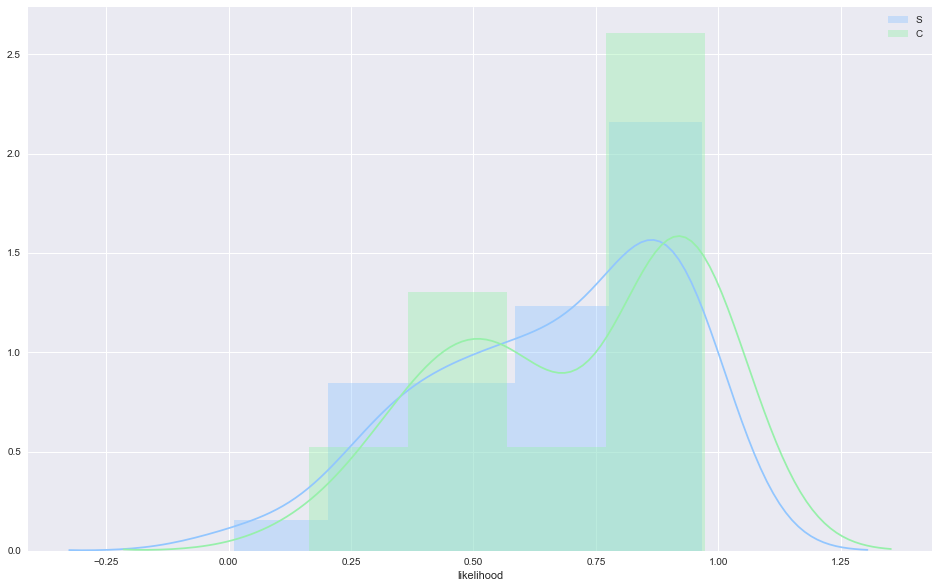

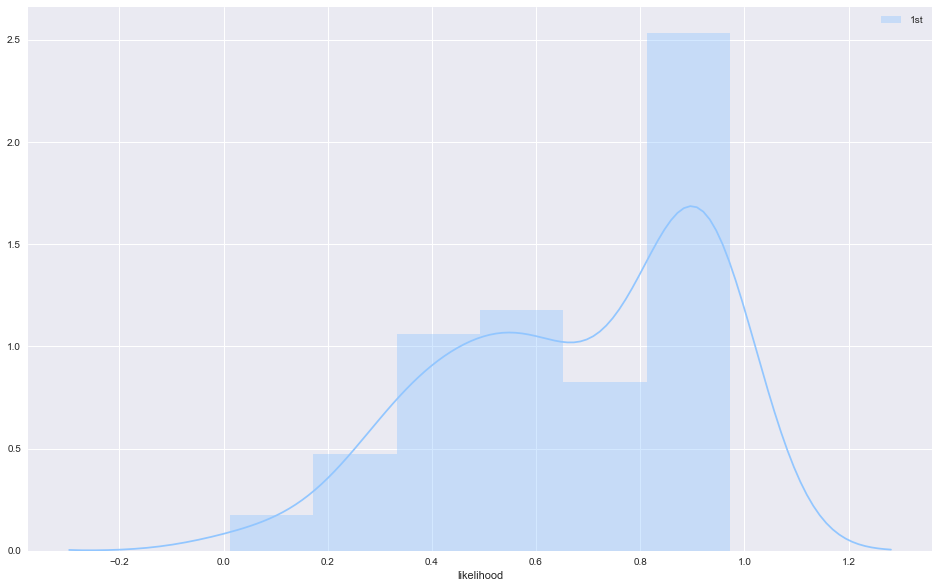

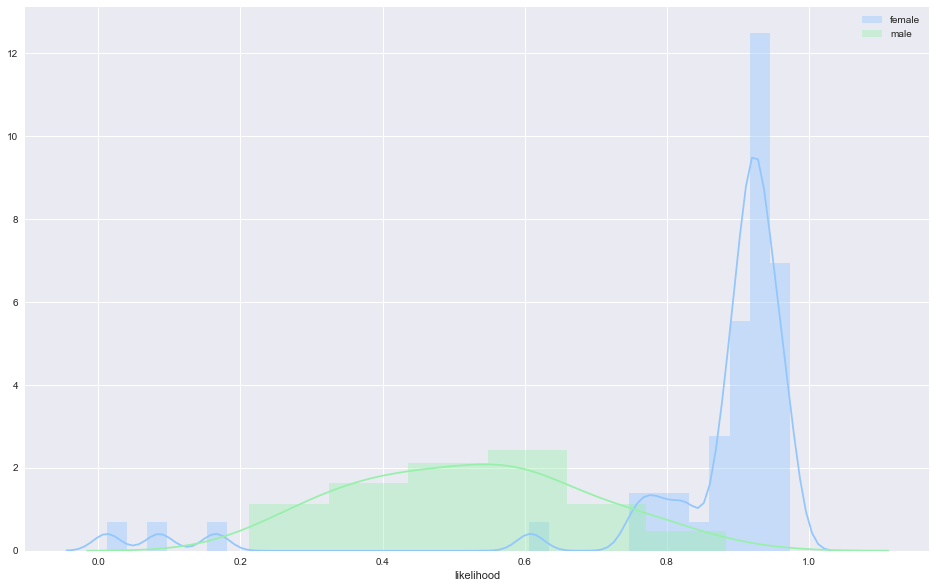

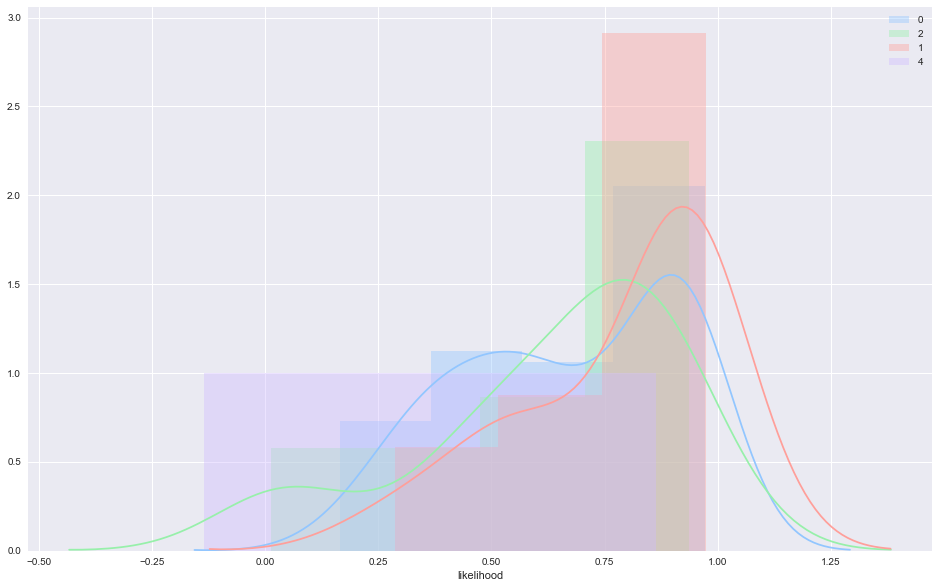

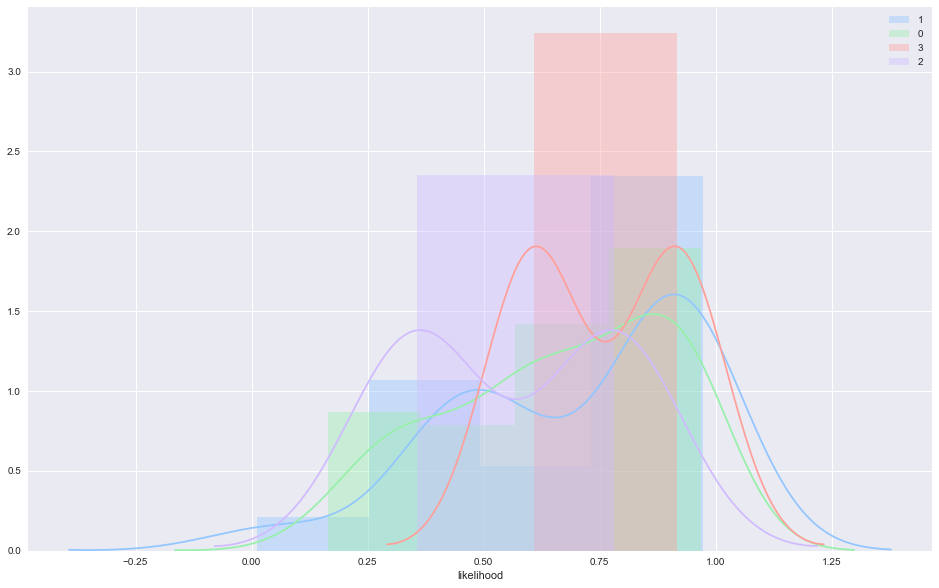

In [119]:
for x in subs.drop("likelihood",1):
    plot_cat(subs, x)

- 1stかつmaleの尤度が低いことが分かった

In [121]:
subs[subs.sex=="male"]

,embarked,pclass,sex,parch,sibsp,likelihood
id,,,,,,
23,S,1st,male,0,0,0.439323
83,S,1st,male,0,0,0.527313
110,S,1st,male,0,0,0.633018
137,S,1st,male,0,1,0.572221
139,C,1st,male,0,0,0.359989
168,S,1st,male,0,0,0.602502
174,C,1st,male,0,0,0.660919
209,C,1st,male,0,0,0.414148
224,S,1st,male,0,1,0.484435


In [123]:
cats

,embarked,pclass,sex,parch,sibsp
id,,,,,
3,S,1st,female,0,1
4,S,3rd,male,0,0
7,S,3rd,male,1,3
9,C,2nd,female,0,1
11,S,1st,female,0,0
13,S,3rd,male,5,1
16,Q,3rd,male,1,4
19,C,3rd,female,0,0
23,S,1st,male,0,0
